In [1]:
%matplotlib notebook

In [357]:
# Import dependencies

import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import datetime
import os, sys


from pprint import pprint
from config import api_keys


# Wrangling the Data

In [2]:
# Import data

filename1 = 'Resources/country_population.csv'
filename2 = 'Resources/fertility_rate.csv'
filename3 = 'Resources/life_expectancy.csv'

country_population = pd.read_csv(filename1)
fertility_rate = pd.read_csv(filename2)
life_expectancy = pd.read_csv(filename3)



In [3]:
# Cleaning up life expectancy data frame.
# Transposes dataframe and drops rows that aren't needed for calculations.


life_expectancy_transposed = life_expectancy.transpose()
life_expectancy_transposed.columns = life_expectancy_transposed.iloc[0]
life_expectancy_transposed = life_expectancy_transposed.drop(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'])
life_expectancy_transposed = life_expectancy_transposed.dropna(axis = 'columns',how = 'any')

life_expectancy_transposed.head()


Country Name,Aruba,Afghanistan,Angola,Albania,Arab World,United Arab Emirates,Argentina,Armenia,Antigua and Barbuda,Australia,...,"Venezuela, RB",Virgin Islands (U.S.),Vietnam,Vanuatu,World,Samoa,"Yemen, Rep.",South Africa,Zambia,Zimbabwe
1960,65.662,32.292,33.251,62.279,46.8251,52.265,65.022,65.971,62.115,70.8171,...,59.253,66.2249,59.041,46.441,52.5717,49.748,34.361,52.215,45.124,51.565
1961,66.074,32.742,33.573,63.298,47.4077,53.312,65.141,66.402,62.555,70.9732,...,59.829,66.488,59.722,47.044,53.0775,50.249,34.471,52.559,45.502,51.938
1962,66.444,33.185,33.914,64.187,47.9889,54.349,65.233,66.837,62.979,70.9424,...,60.395,66.7411,60.391,47.648,53.5016,50.75,34.739,52.894,45.869,52.3
1963,66.787,33.624,34.272,64.911,48.5722,55.375,65.311,67.276,63.385,70.9117,...,60.948,66.9962,61.024,48.251,54.0355,51.252,35.187,53.229,46.225,52.651
1964,67.113,34.06,34.645,65.461,49.1592,56.385,65.388,67.715,63.774,70.881,...,61.488,67.2604,61.585,48.853,54.7152,51.756,35.815,53.571,46.574,52.993


In [4]:
# Life expectancy averages from last 10 years

LE_10years = life_expectancy_transposed.iloc[range(46,57),:]

avg_life_10_years = pd.DataFrame(LE_10years.mean().sort_values(ascending = False))
avg_life_10_years = avg_life_10_years.rename(columns = {0 : 'Avg Life Expectancy (2006-2016)'})
avg_life_10_years = avg_life_10_years.reset_index()

avg_life_10_years.head()

,Country Name,Avg Life Expectancy (2006-2016)
0,"Hong Kong SAR, China",83.277384
1,Japan,83.052417
2,"Macao SAR, China",82.877000
3,Switzerland,82.427051
4,Italy,82.106430


In [5]:
# Set criteria for highest where highest is 80 years and above.
# 26 countries fall under this criteria

top_avg_life_10_years = avg_life_10_years.loc[avg_life_10_years["Avg Life Expectancy (2006-2016)"] > 80]
top_avg_life_10_years = top_avg_life_10_years.drop(index = 14).reset_index(drop = True)  # drops 'euro area' because it's not a country

top_avg_life_10_years.head()

,Country Name,Avg Life Expectancy (2006-2016)
0,"Hong Kong SAR, China",83.277384
1,Japan,83.052417
2,"Macao SAR, China",82.877000
3,Switzerland,82.427051
4,Italy,82.106430


In [6]:
# Set criteria for lowest life expectancy where lowest is 60 years and below.
# 30 countries fall under this criteria

bot_avg_life_10_years = avg_life_10_years.loc[avg_life_10_years["Avg Life Expectancy (2006-2016)"] < 60]
bot_avg_life_10_years = bot_avg_life_10_years.drop(index = [200,201,203,209,210,211,214]).reset_index(drop = True) # drops regions that aren't countries

bot_avg_life_10_years.head()

,Country Name,Avg Life Expectancy (2006-2016)
0,"Gambia, The",59.842727
1,Liberia,59.817545
2,Benin,59.503273
3,Namibia,59.358091
4,Angola,58.501182


## Cleaning up Data for CIA API 

In [7]:
# Makes a list that cleans up the top and bottom country names so that they will be compatible with key names 
# in CIA WorldFactBook API

country_names_top = list(top_avg_life_10_years['Country Name'])

top_country_names = [country.lower().replace(" ","_") for country in country_names_top ]
top_country_names[0] = 'hong_kong'
top_country_names[2] = 'macau'
top_country_names[19] = 'korea_south'

print(top_country_names, '\n')


country_names_bot = list(bot_avg_life_10_years['Country Name'])

bot_country_names = [country.lower().replace(" ","_") for country in country_names_bot ]
bot_country_names[11] = 'congo_democratic_republic_of_the'
bot_country_names[0] = bot_country_names[0].replace(',','')
bot_country_names[26] = "cote_d'_ivoire"

print(bot_country_names)


['hong_kong', 'japan', 'macau', 'switzerland', 'italy', 'iceland', 'spain', 'australia', 'france', 'singapore', 'sweden', 'canada', 'norway', 'luxembourg', 'new_zealand', 'netherlands', 'malta', 'austria', 'ireland', 'korea_south', 'greece', 'united_kingdom', 'finland', 'belgium', 'channel_islands', 'germany'] 

['gambia_the', 'liberia', 'benin', 'namibia', 'angola', 'malawi', 'togo', 'burkina_faso', 'south_africa', 'uganda', 'niger', 'congo_democratic_republic_of_the', 'zambia', 'guinea', 'equatorial_guinea', 'cameroon', 'mali', 'guinea-bissau', 'burundi', 'mozambique', 'somalia', 'zimbabwe', 'south_sudan', 'swaziland', 'nigeria', 'lesotho', "cote_d'_ivoire", 'chad', 'sierra_leone', 'central_african_republic']


## Creating the Dataframes from CIA API ##

In [191]:
def makedict(jsonfile,country_list1, dic1, country_list2, dic2):
    '''
    Makes 2 dictionaries for 2 country lists for their respective industries.
    country_list is your list of countries, and dic is an empty dictionary. This was designed for both the top and bottom
    countries for life expectancy.
    '''
    
    with open(jsonfile, 'r', errors = 'ignore') as f:
        data = json.loads(f.read())
    
        for country in country_list1:
            try:
                sectors = data['countries'][country]['data']['economy']['gdp']['composition']['by_sector_of_origin']['sectors']
                agriculture_value = data['countries'][country]['data']['economy']['gdp']['composition']['by_sector_of_origin']['sectors']['agriculture']['value']
                industry_value = data['countries'][country]['data']['economy']['gdp']['composition']['by_sector_of_origin']['sectors']['industry']['value']
                services_value = data['countries'][country]['data']['economy']['gdp']['composition']['by_sector_of_origin']['sectors']['services']['value']
                date = data['countries'][country]['data']['economy']['gdp']['composition']['by_sector_of_origin']['date']
                
                dic1[country] = sectors
                dic1[country]['agriculture'] = agriculture_value
                dic1[country]['industry'] = industry_value
                dic1[country]['services'] = services_value    
#                 dic1[country]['date'] = date
                
            except:
                pass
        
        for country in country_list2:
            try:
                sectors = data['countries'][country]['data']['economy']['gdp']['composition']['by_sector_of_origin']['sectors']
                agriculture_value = data['countries'][country]['data']['economy']['gdp']['composition']['by_sector_of_origin']['sectors']['agriculture']['value']
                industry_value = data['countries'][country]['data']['economy']['gdp']['composition']['by_sector_of_origin']['sectors']['industry']['value']
                services_value = data['countries'][country]['data']['economy']['gdp']['composition']['by_sector_of_origin']['sectors']['services']['value']
                date = data['countries'][country]['data']['economy']['gdp']['composition']['by_sector_of_origin']['date']
                
                dic2[country] = sectors
                dic2[country]['agriculture'] = agriculture_value
                dic2[country]['industry'] = industry_value
                dic2[country]['services'] = services_value
#                 dic2[country]['date'] = date
                
            except:
                pass

In [388]:
# Creates a list of dataframes for the top and bottom countries for life expectancy for the past 10 years (2007-2017).
# Every entry in the list corresponds to a year. df_top[0] is 2007 and so on...

df_top = []
df_bot = []

directory = os.fsencode('Resources/10_year_CIA')

for file in os.listdir(directory):
    top_dict = {}
    bot_dict = {}
    filename = os.fsdecode(file)
    if filename.endswith("_factbook.json"):
        makedict(f'Resources/10_year_CIA/{filename}',top_country_names, top_dict, bot_country_names, bot_dict)
        df_top.append(pd.DataFrame(top_dict).transpose().reset_index().rename(columns = {'index': 'country'}))
        df_bot.append(pd.DataFrame(bot_dict).transpose().reset_index().rename(columns = {'index': 'country'}))
        


In [382]:
def clean_country_name(listdf):
    
    '''This function replaces snakecase country names (used for API compatibility) with titlecased names.'''
    
    for df in listdf:
        df['country'] = df['country'].str.title()        
        df['country'] = df['country'].str.replace("_"," ")
        df.set_index('country', inplace = True,drop = True)
        df.rename(columns = {'agriculture': 'Agriculture', 'industry': 'Industry', 'services':'Services'},inplace = True)
             

In [389]:
# Runs the function to clean up country names

clean_country_name(df_top)
clean_country_name(df_bot)    


In [393]:
# In 2013, Austria's entry contained a typo which added percentages to over 100. Dropped Austria for that year.
try:
    df_top[6].drop(index = 'Austria',inplace = True)
    df_top[6]
except KeyError:
    print('Austria already dropped.')

Austria already dropped.


In [375]:
def make_hbar_chart(dataframe_list,figsize,start_year,folder_name):
    '''
    This function takes in 3 arguments:

    dataframe_list is a list of dataframes,
    figsize is a tuple for length and width eg:(10,6),
    and start_year is the year which the dataframes start.

    This function populates a horizontal bar graph for every year that corresponds to the data frame in the list
    given.
    
    '''

    path = f"/{folder_name}"
    os.mkdir(folder_name)
    
    for df in dataframe_list:
        df.iloc[::-1].plot(kind="barh",stacked = True, figsize=figsize, color = ('blue','red','green'), 
                           edgecolor = 'black',alpha = .45)

        plt.title(f"Industry by Country {start_year}", loc = 'left')
        plt.xlabel("Percent of Industry")
        plt.ylabel("Country")
        plt.legend(loc='upper left', bbox_to_anchor=(0.47, 1.04),ncol=3, fancybox=True, shadow=True)

        plt.grid()

        plt.tight_layout()



        plt.savefig(f'{folder_name}/Industries by Country {start_year}.png')
        plt.show()
        start_year +=1

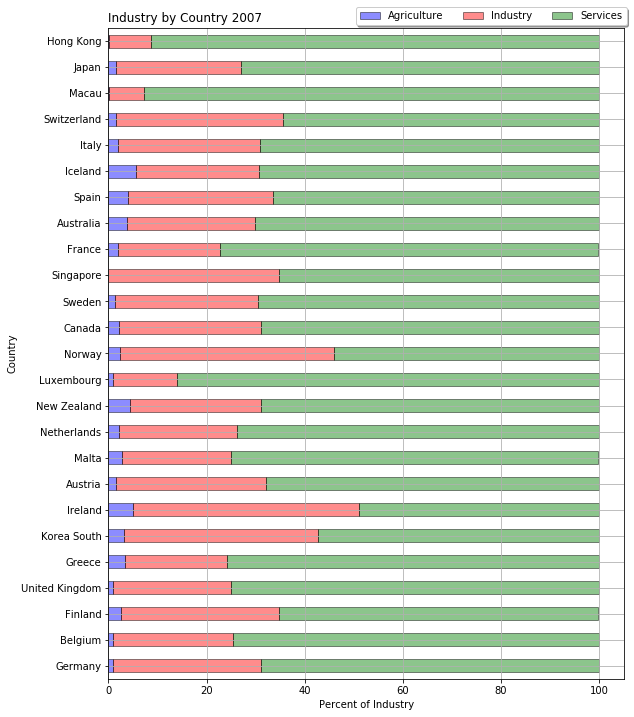

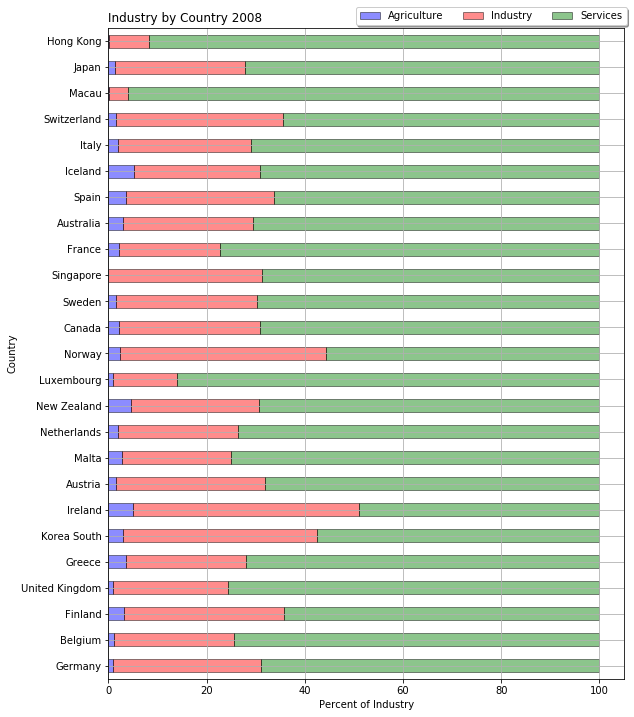

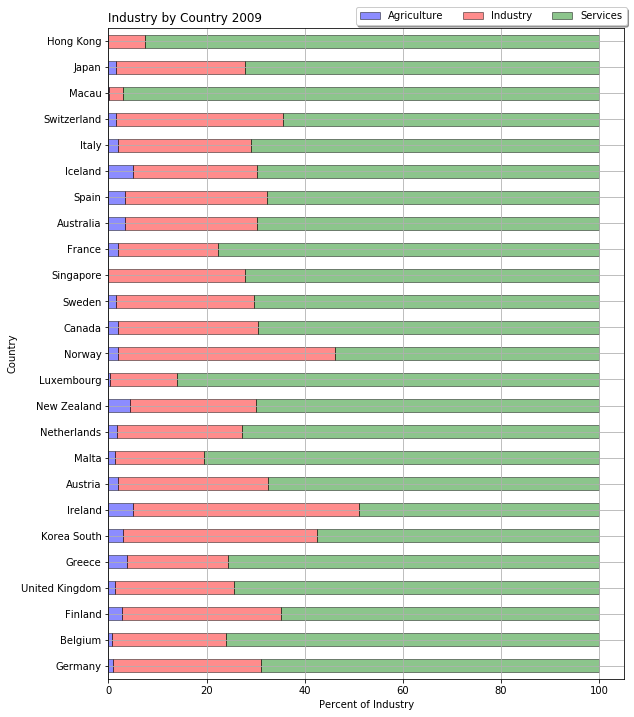

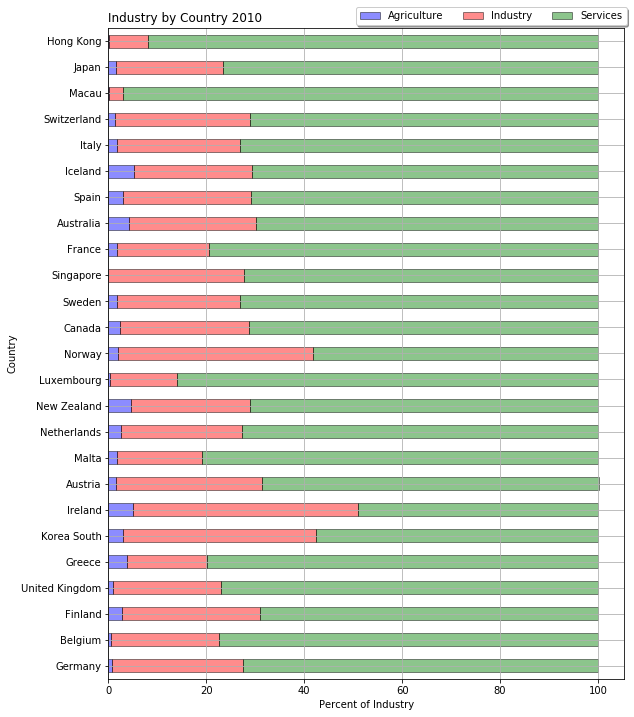

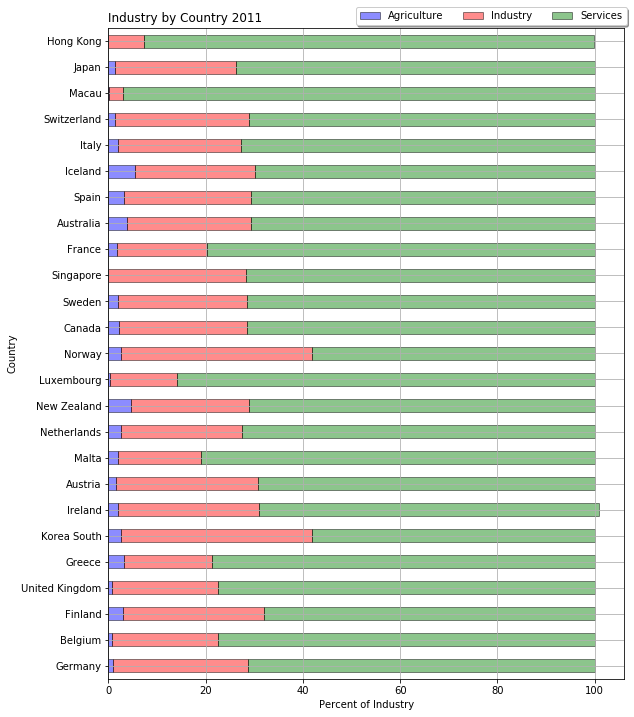

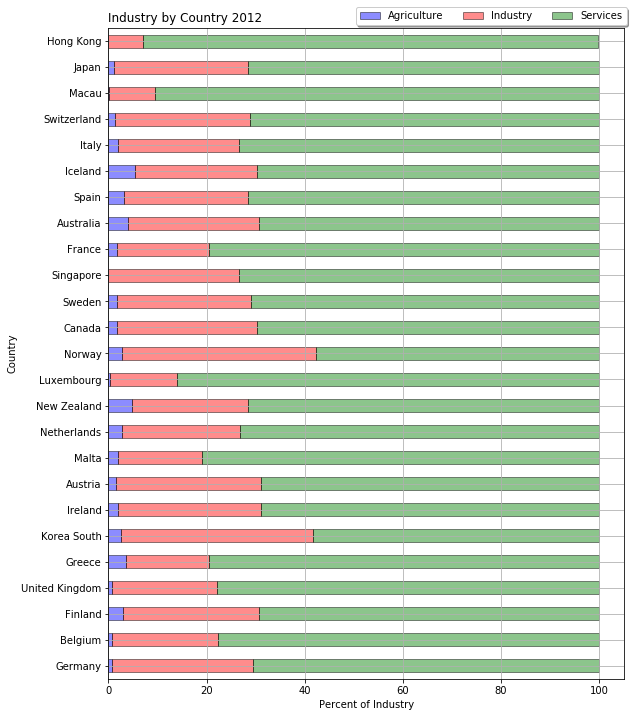

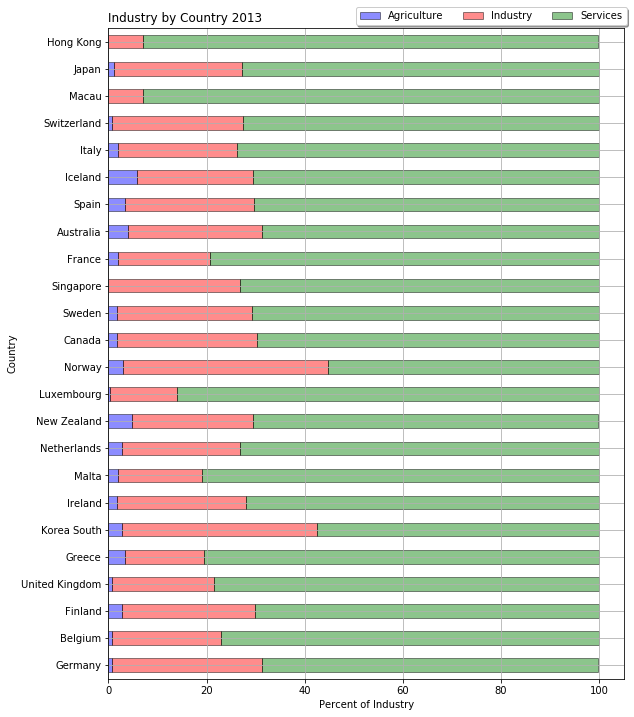

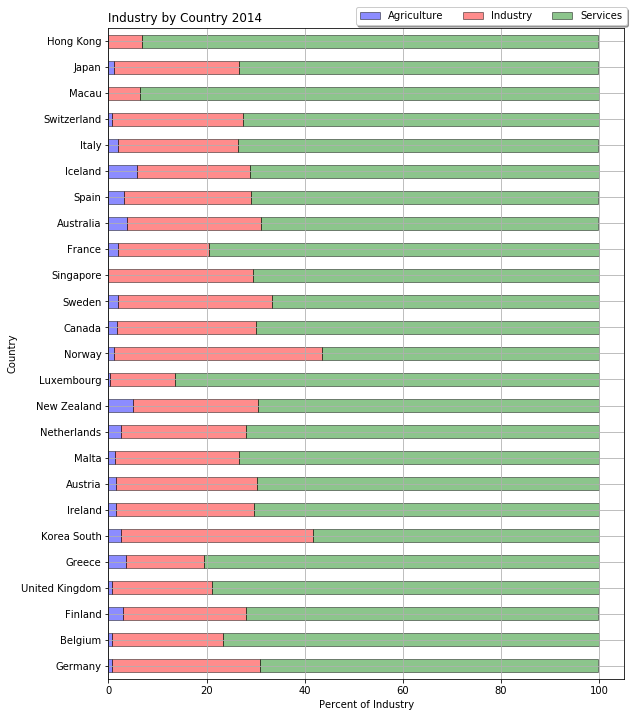

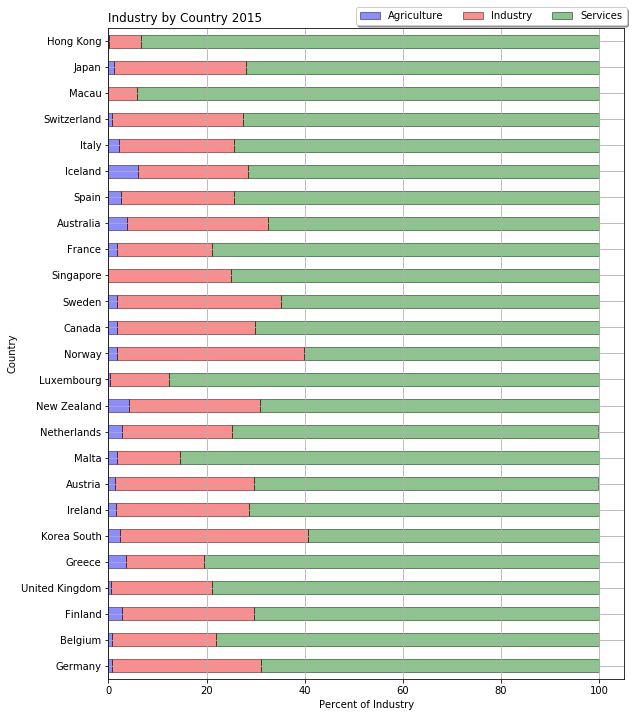

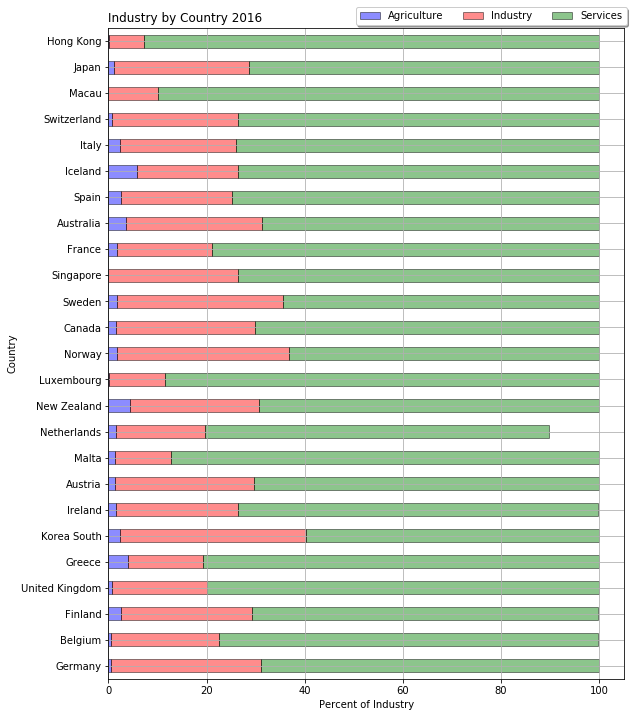

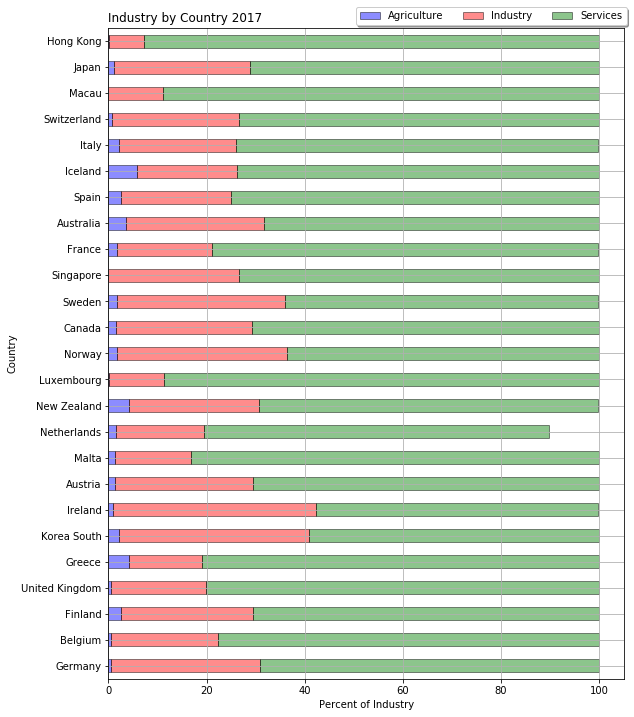

In [392]:
# Populates bar charts for top countries for life expectancy

make_hbar_chart(df_top,(9,10),2007,'top_countries_industry')

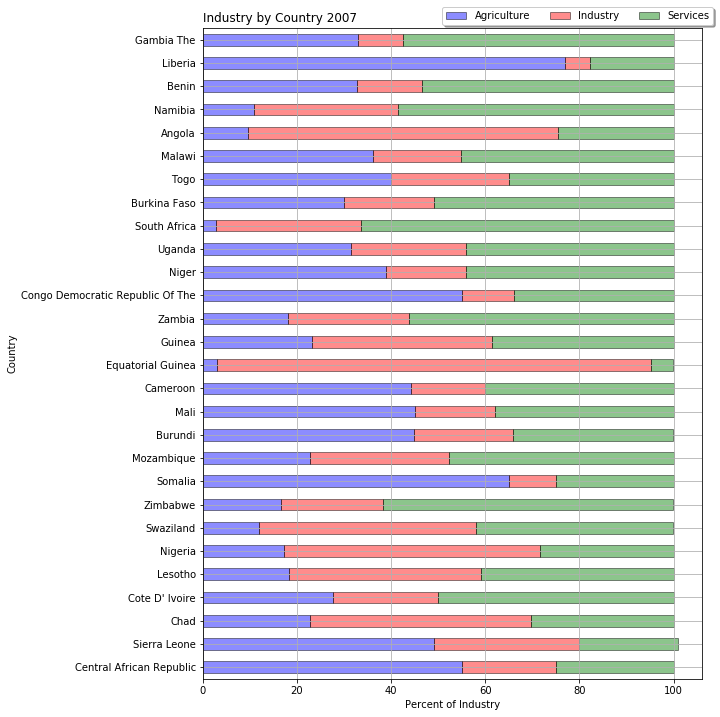

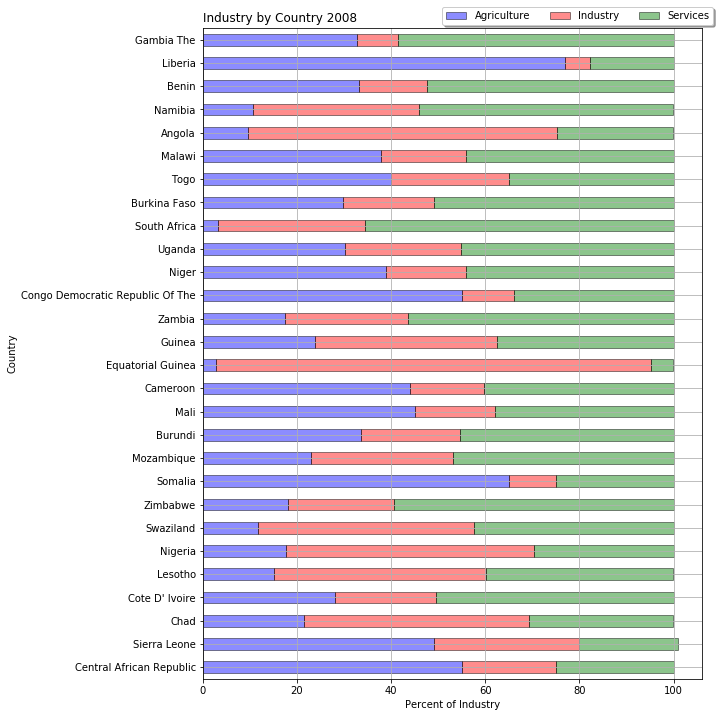

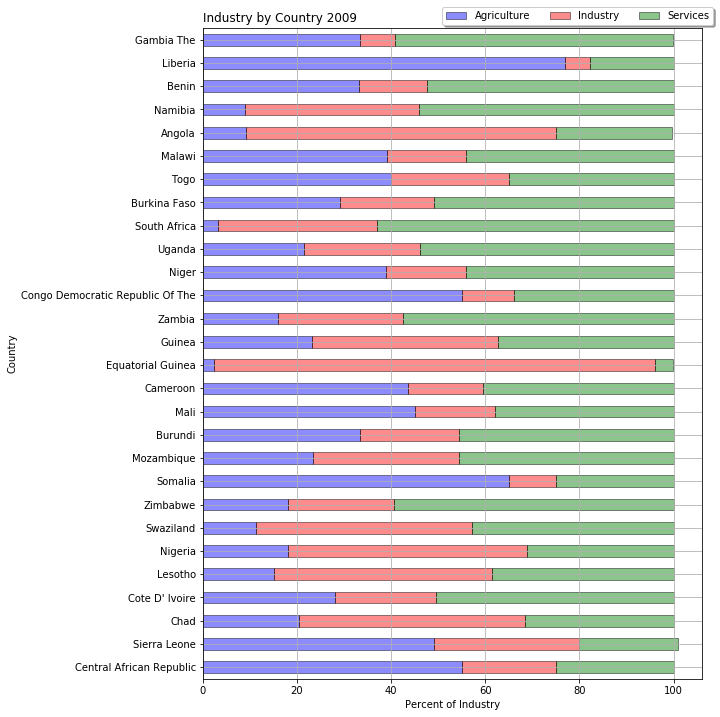

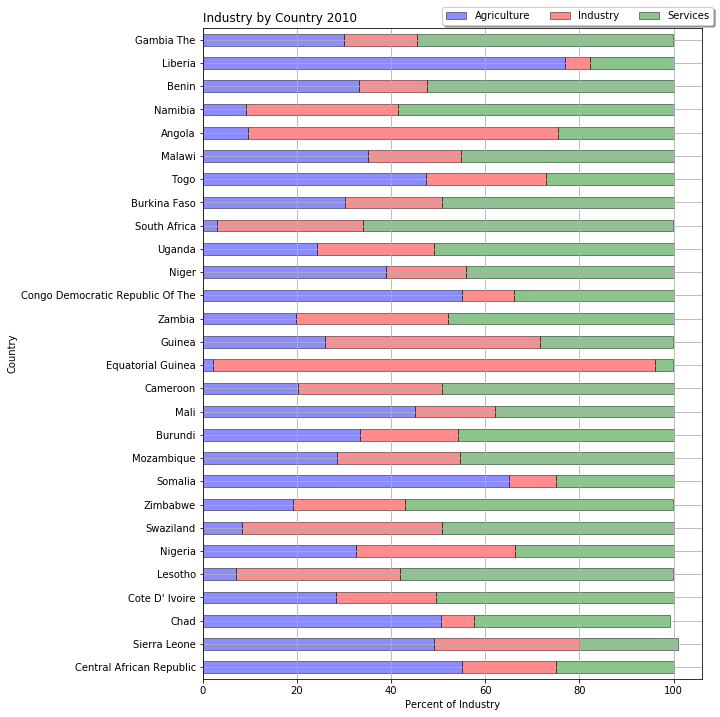

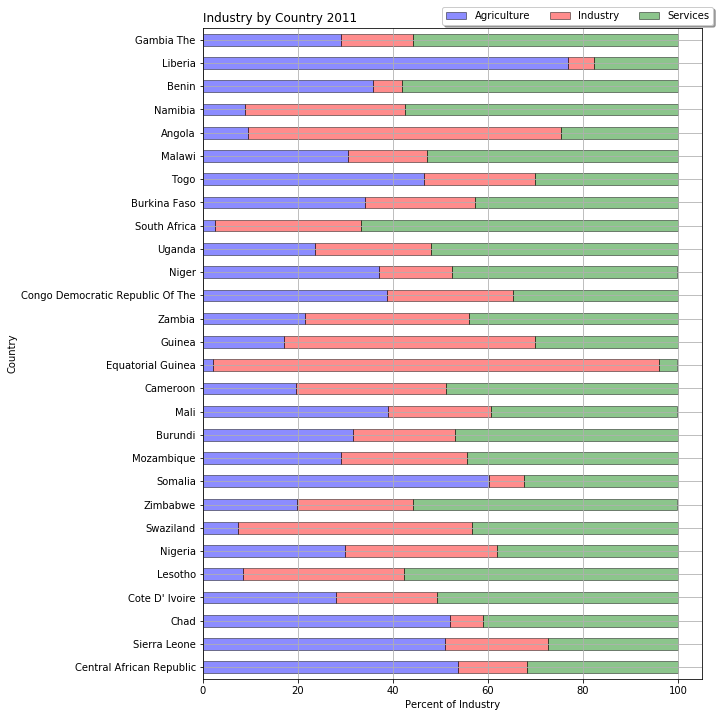

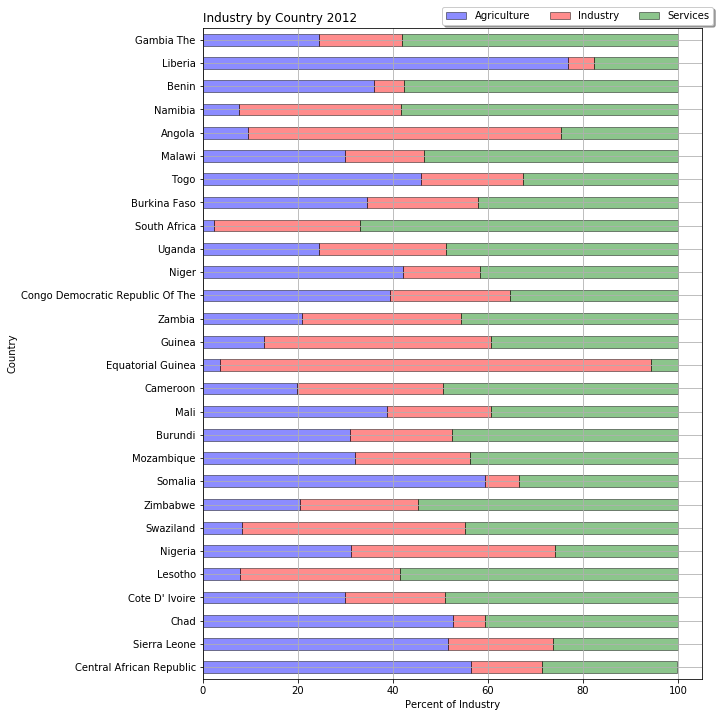

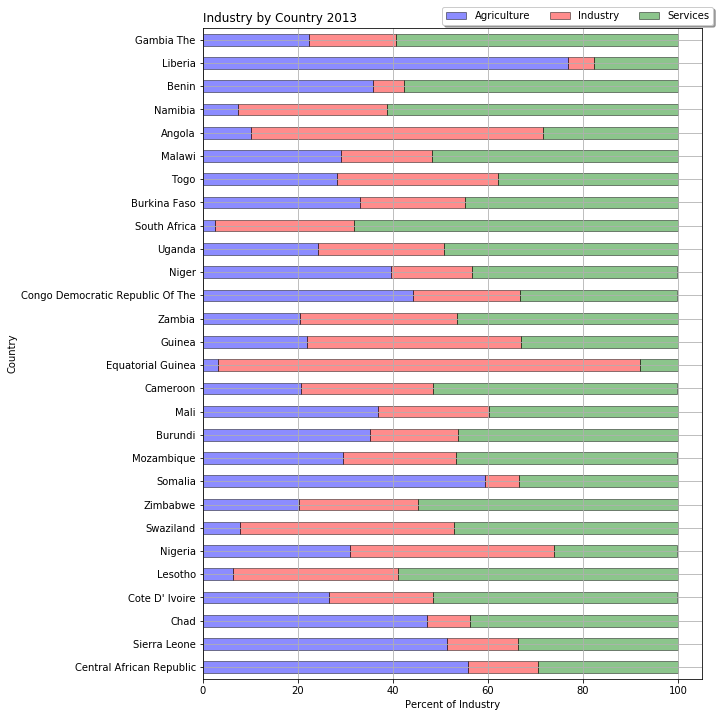

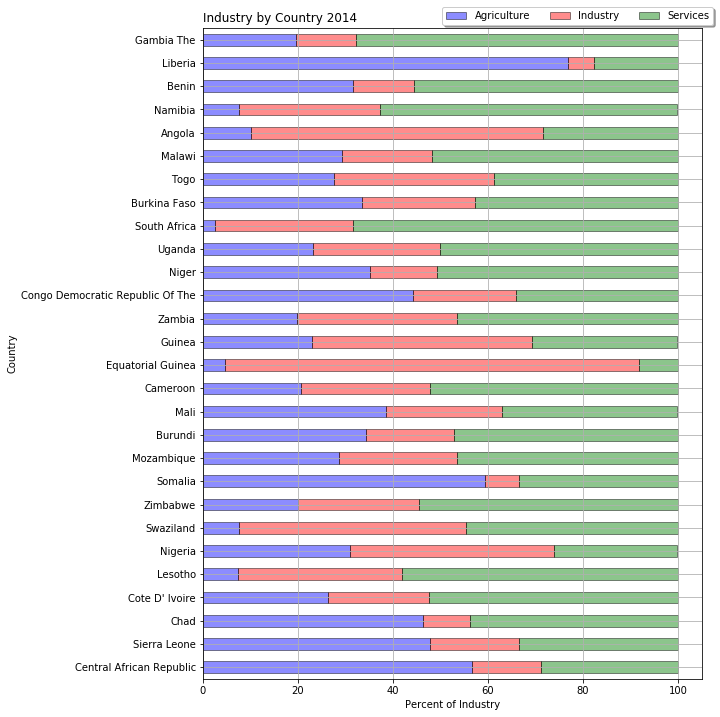

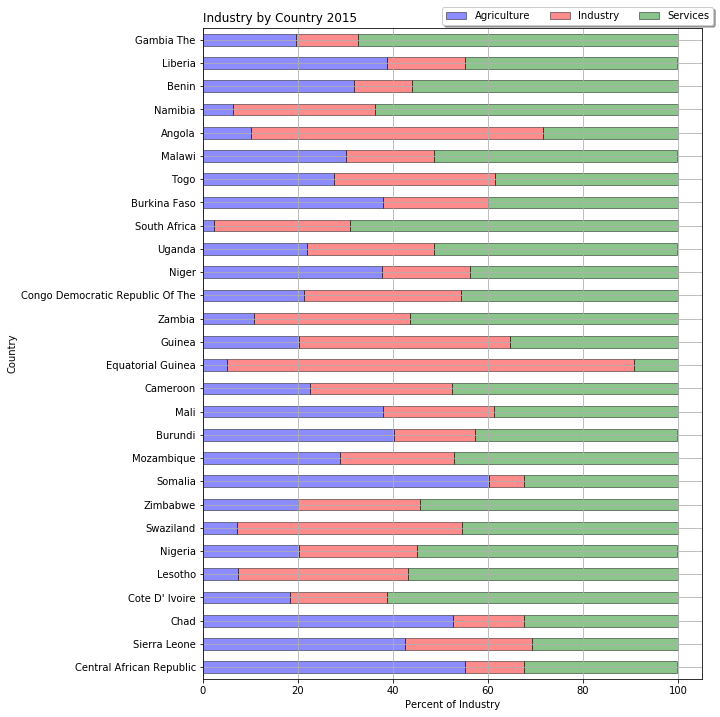

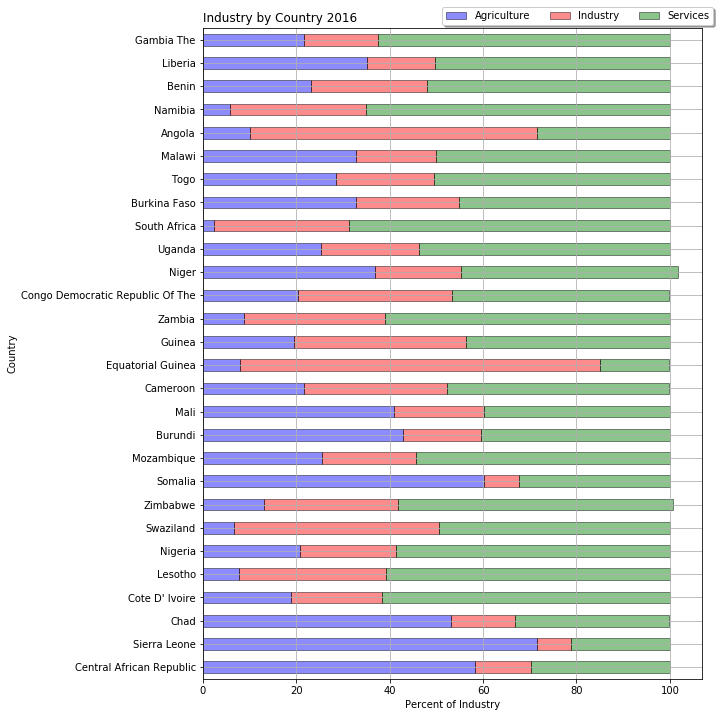

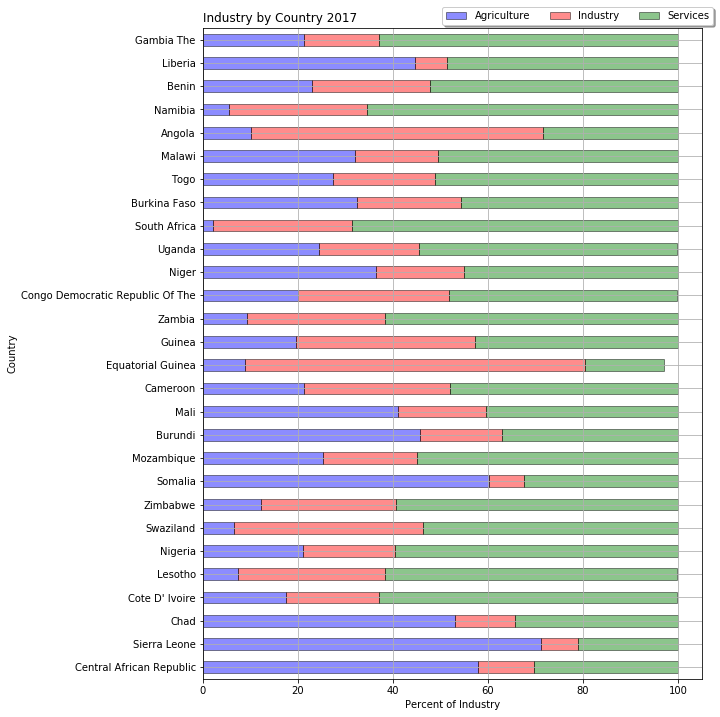

In [394]:
# Populates bar charts for bottom countries for life expectancy

make_hbar_chart(df_bot,(10,10),2007,'bottom_countries_industry')

## Appendix (extra code that didn't make the cut)

In [246]:
# Goes through ALL of the json files that were pulled from CIA Factbook from resources, extracts industry information
# for each country with high and low life expectancy and stores all the info in a list of dataframes.

# checker = True

# start_date = datetime.datetime.strptime('2007-06-18', '%Y-%m-%d')

# end_date = datetime.datetime.strptime('2017-08-30', '%Y-%m-%d')

# # print(end_date.strftime('%Y-%m-%d'))


# df_top = []
# df_bot = []


# while start_date.strftime('%Y-%m-%d') < end_date.strftime('%Y-%m-%d'):

    
#     JsonFile = f"Resources/weekly_json/{start_date.strftime('%Y-%m-%d')}_factbook.json"

#     dic = {}
#     dic2 = {}

#     with open(JsonFile, 'r', errors = 'ignore') as f:
#         objects = json.loads(f.read())
#         try:
#             for top, bot in zip(top_country_names,bot_country_names):
#                 dic[top] = objects['countries'][top]['data']['economy']['industries']['industries']
#                 dic2[bot] = objects['countries'][bot]['data']['economy']['industries']['industries']
#         except:
#             checker = False
            
#         df_top.append(pd.DataFrame.from_dict(dic, orient = 'index').transpose())
#         df_bot.append(pd.DataFrame.from_dict(dic2, orient = 'index').transpose())
#     print(start_date)
#     start_date += datetime.timedelta(days=7)

        

In [1]:
# print(len(df_top))
# print(len(df_bot))

In [8]:
# x = 'Resources/weekly_json/2007-06-18_factbook.json'

# dic = {}
# dic2 = {}

# with open(JsonFile, 'r') as f:
#     objects = json.loads(f.read())
# #     country = list(objects['countries'].keys())
#     try:
#         for top, bot in zip(top_country_names,bot_country_names):
#             dic[top] = objects['countries'][top]['data']['economy']['industries']['industries']
#             dic2[bot] = objects['countries'][bot]['data']['economy']['industries']['industries']
        
#     except:
#         print(f'{top} not counted as country')

        
# pprint(dic)
# pprint(dic2)

In [249]:
# year = [x for x in range(2007,2018,1)]
# print(year)